# Calibração de câmera
## Curso de Fotografia Computacional

### Imports e funções de utilidade

In [ ]:
%%capture
!pip install timm

In [ ]:
import glob
import yaml
from tqdm import tqdm
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import struct

In [ ]:
np.set_printoptions(suppress=True)

In [ ]:
def show_image(img, figsize=(30, 15), cmap="gray"):
  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(1, 1, 1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(img, cmap=cmap)
  plt.show()

def show_images(img_list, figsize=None, cmap="gray"):
  n = len(img_list)
  if figsize == None:
    figsize = (5 * n, 8)
  fig, ax = plt.subplots(1, n, figsize=figsize)
  for i in range(n):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(img_list[i], cmap=cmap)
  plt.show()

### Carregando imagens
Fazer upload do zip no drive (lembre-se de montar o drive no Colab) e alterar o caminho abaixo

In [ ]:
%%capture
!unzip drive/MyDrive/fotocomp/data_edge30ultra.zip -d .

#### Execução da calibração

In [ ]:
# Critérios de paradas
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)

# Flags de calibração
calib_flags = cv2.CALIB_CB_ADAPTIVE_THRESH \
                + cv2.CALIB_CB_NORMALIZE_IMAGE \
                + cv2.CALIB_CB_FAST_CHECK

CHECKERBOARD = (8, 6) # (altura, largura)
SIZE = 25 #mm

# Construções de possíveis pontos do "mundo"
objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0, :, :2] = np.mgrid[:CHECKERBOARD[0], :CHECKERBOARD[1]].T.reshape(-1, 2)
objp *= SIZE

# Listas para pontos do "mundo" e pontos de imagem
objpoints = []
imgpoints = []

files = glob.glob("data_edge30ultra/*")
n_ok = 0

for filename in tqdm(files):
    img = cv2.imread(filename)
    img = cv2.resize(img, None, fx=1/2, fy=1/2)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Encontrar pontos na imagem
    ok, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None, calib_flags)
    if ok:
        n_ok += 1
        objpoints.append(objp)

        # Refinar coordenadas
        corners2 = cv2.cornerSubPix(gray, corners, (4, 4), (-1, -1), criteria)
        imgpoints.append(corners2)

print(f"Percentage of usable images: {n_ok / len(files)}")

# Calibrar camera com os dados encontrados
_, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints,
    imgpoints,
    gray.shape[::-1],
    None,
    None
)

with open('matrix.npy', 'wb') as f:
	np.save(f, mtx)

with open('dist_coeff.npy', 'wb') as f:
	np.save(f, dist)

with open('rvecs.npy', 'wb') as f:
	np.save(f, rvecs)

with open('tvecs.npy', 'wb') as f:
	np.save(f, tvecs)

100%|██████████| 58/58 [00:32<00:00,  1.81it/s]


Percentage of usable images: 0.9827586206896551


### Remoção de distorção

In [ ]:
images = glob.glob("IMG_*")

In [ ]:
img_id = np.random.randint(0, len(images))
img_id

3

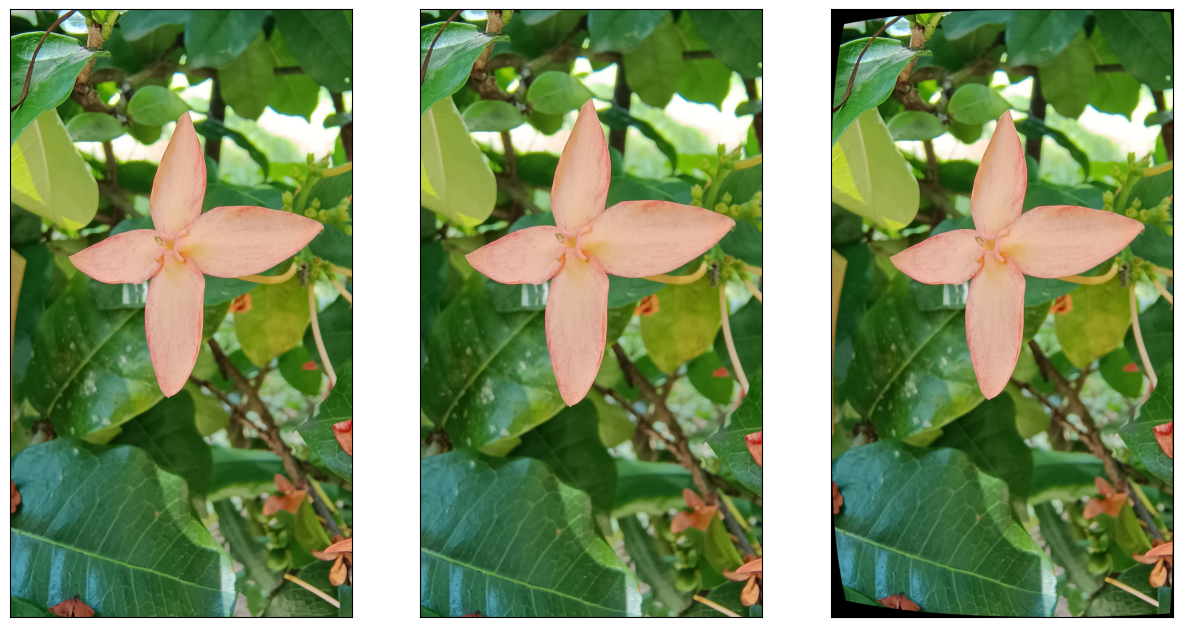

True

In [ ]:
%matplotlib inline
image = cv2.imread(images[img_id])[..., ::-1]
image = cv2.resize(image, None, fx=1/2, fy=1/2)
h, w = image.shape[:2]

scaled_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
roi_x, roi_y, roi_w, roi_h = roi
undistorted_ = cv2.undistort(
    image, mtx, dist, None, scaled_camera_matrix,
)

undistorted_ = cv2.resize(undistorted_, (w, h), interpolation=cv2.INTER_LANCZOS4)
undistorted = undistorted_[roi_y:roi_y + roi_h, roi_x:roi_x + roi_w]
undistorted = cv2.resize(undistorted, (w, h), interpolation=cv2.INTER_LANCZOS4)

show_images([i for i in [image, undistorted, undistorted_]])
cv2.imwrite("undistorted.png", undistorted[..., ::-1])

### Computação da profundidade

Dispositivo de inferência

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

Carregamento do modelo e função de preprocessamento

In [ ]:
mde_model = torch.hub.load("intel-isl/MiDaS", "MiDaS", trust_repo=True)
mde_model.to(device)
mde_model.eval()

Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


Loading weights:  None


Downloading: "https://github.com/facebookresearch/WSL-Images/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/ig_resnext101_32x8-c38310e5.pth" to /root/.cache/torch/hub/checkpoints/ig_resnext101_32x8-c38310e5.pth
100%|██████████| 340M/340M [00:03<00:00, 95.0MB/s]
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v2_1/midas_v21_384.pt" to /root/.cache/torch/hub/checkpoints/midas_v21_384.pt
100%|██████████| 403M/403M [00:01<00:00, 285MB/s]


MidasNet(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inpla

In [ ]:
transform = torch.hub.load("intel-isl/MiDaS", "transforms", trust_repo=True).dpt_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Inferência

In [ ]:
shape = image.shape[:2]

# Preprocessar
img = transform(undistorted)

# Mover para dispositivo
img = img.to(device)

# Previsão
with torch.no_grad():
    depth = mde_model(img)              # [1, altura, largura] (torch.Tensor)
depth = depth.cpu().squeeze()           # [altura, largura] (torch.Tensor)
depth = depth.numpy()                   # [altura, largura] (numpy.ndarray)

Inversão e resize

In [ ]:
depth = np.nan_to_num(depth, nan=0.0, posinf=0.0, neginf=0.0)
d_max = depth.max()
depth = 1 - (depth - depth.min()) / (depth.max() - depth.min())

In [ ]:
depth = np.clip(depth, 1e-2, 1)

In [ ]:
depth = cv2.resize(depth, shape[::-1], interpolation=cv2.INTER_LANCZOS4)

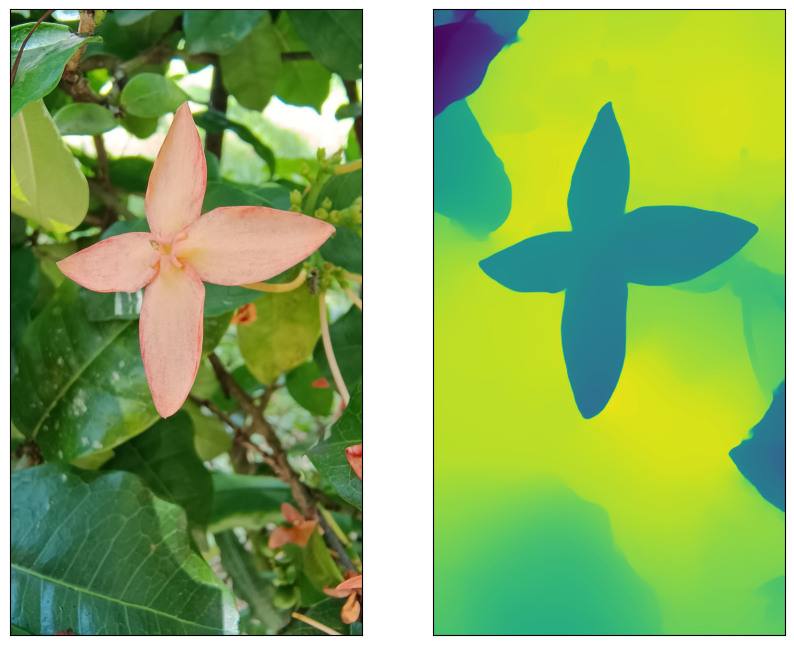

In [ ]:
%matplotlib inline
show_images([undistorted, depth], (10, 10), cmap="viridis")

In [ ]:
cv2.imwrite("rgb.png", cv2.resize(undistorted[..., ::-1], None, fx=1/4, fy=1/4))
cv2.imwrite("depth.png", cv2.resize(255 - depth * 255, None, fx=1/4, fy=1/4))

True

### Projeção em 3d (inexata)


In [ ]:
height, width = depth.shape
points = np.zeros((height * width, 3))
colors = np.zeros((height * width, 3))

c_x = scaled_camera_matrix[0, 2]
c_y = scaled_camera_matrix[1, 2]
f_x = scaled_camera_matrix[0, 0]
f_y = scaled_camera_matrix[1, 1]

i = 0
for v in tqdm(range(height)):
    for u in range(width):
        z = depth[v, u]
        x = (u - c_x) / f_x
        y = (v - c_y) / f_y
        points[i] = (x, y, z)
        colors[i] = (undistorted[v, u] / 255)
        i += 1

100%|██████████| 2104/2104 [00:14<00:00, 142.42it/s]


In [ ]:
%%capture
!pip install ipympl

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

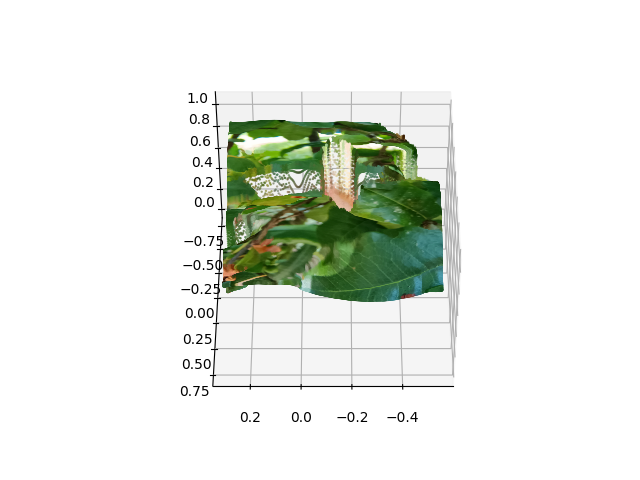

In [ ]:
%matplotlib widget
figure = plt.figure()
axis = figure.add_subplot(projection='3d')
axis.view_init(elev=45, azim=90)

idx = np.arange(0, len(points), 4, dtype=int)[:-1]
x = points[..., 0][idx]
y = points[..., 1][idx]
z = points[..., 2][idx]

axis.scatter(x, y, z, s=0.5, c=colors[idx])
plt.show()

In [ ]:
pointcloud_file = open("pointcloud.ply", "wb")
pointcloud_file.write(bytes("ply\n", "utf-8"))
pointcloud_file.write(bytes("format binary_little_endian 1.0\n", "utf-8"))
pointcloud_file.write(bytes(f"element vertex {points.shape[0]}\n", "utf-8"))
pointcloud_file.write(bytes("property float x\n", "utf-8"))
pointcloud_file.write(bytes("property float y\n", "utf-8"))
pointcloud_file.write(bytes("property float z\n", "utf-8"))
pointcloud_file.write(bytes("property uchar red\n", "utf-8"))
pointcloud_file.write(bytes("property uchar green\n", "utf-8"))
pointcloud_file.write(bytes("property uchar blue\n", "utf-8"))
pointcloud_file.write(bytes("end_header\n", "utf-8"))

colors_ = (colors * 255).astype("uint8")
for i in tqdm(range(points.shape[0])):
    xyz = tuple(points[i].tolist())
    col = tuple(c.tobytes() for c in colors_[i])
    array = bytearray(struct.pack("fffccc", *xyz, *col))
    pointcloud_file.write(array)
pointcloud_file.close()

100%|██████████| 2491136/2491136 [00:14<00:00, 172603.23it/s]


Usar visualizador de .ply para visualizar (como o [MeshLab](https://github.com/cnr-isti-vclab/meshlab#releases)) ou fazer o upload das imagens de profundidade e rgb para https://depthmapviewer.ugocapeto.com/ seguindo o descrito em https://www.dropbox.com/s/v18rn9ez8iv8xjg/depth_map_viewer.pdf?dl=0